# Todos
- [x] add todo (jupyter notebook tutorial)
- [x] ipdb on exception
- [x] clean code: remove argparse, run by calling function with suitable arguments
-  ~~write evaluation of upper bound performance of an abstraction~~ (This is useless since when there are 40 abstraction states, the number of policy is $4^{40}$, impossible to find out the best one)
- [x] generate abstractions with different n_goal and n_abs, select some of them to do multi-task training and transfer
    - run 12 tasks on identity map
    - run 12 tasks on 12-44 pos abstract map
    - run 1 task on 12-44 pos abstract map
- [x] vanilla alternative training for prob and vq
- [x] try window size = 1 (otherwise it is impossible to visualize abs)
    - [ ] why it does not work?
- [x] try to log text on the config: including git code
- [x] visualization of abs at each step
- [x] try nonlinear actor for vq (does not work)
- [x] change critic to abstract state critic (does not work)
- [ ] implement sampling abs_encoder
- [ ] try I2A modeling
- [ ] get rid of the time stamp in tf_log
- [ ] make plots for all log with same attrubites
- [ ] offline encoder training? (For VQ)
- [x] run 12 tasks for feature baseline
- [ ] centralized and resumable experiment
    - looking at the structure of the train.py, you see that you need args, setup_fn which takes args and return agent, and train_fn which task agent and config
    - need a way to archive experiments been ran, even though the result is not good, at least know what is not working
    - combine log and model
    - argparse as a tree
    - manage model and loss by a dictionary
    - do not overlap model and log!
    
# Readings
- [ ] POMDP
- [ ] soft actor-critic
- [ ] Representation learning for RL (alternative training, meta-learning for $\phi$?)

# Settings and Functions

Automatic pdb calling has been turned ON
# of shown colors: 45/47


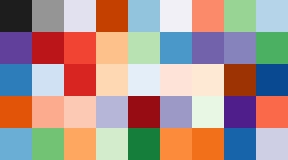

In [30]:
%pdb on

from deep_rl.gridworld import ReachGridWorld, PORGBEnv, ReachGoalManager
import os
import sys 
import random
import argparse
import dill
import json
import itertools
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from collections import Counter, namedtuple
from IPython.display import display
from PIL import Image
from pathlib import Path

def seed(s):
    random.seed(s)
    np.random.seed(s)

seed(0) # set seed 

class one_hot:
    # 1 or 2 dim
    @staticmethod
    def encode(indices, dim):
        if len(indices.shape) > 1:
            indices = indices.squeeze(axis=1)
        assert len(indices.shape) == 1, 'shape error'
        return np.eye(dim)[indices]

    # 2-dim
    @staticmethod
    def decode(vs):
        return np.argmax(vs, 1)

def fload(fn, ftype):
    if ftype == 'json':
        with open(fn) as f:
            return json.load(f)
    elif ftype == 'pkl':
        with open(fn, 'rb') as f:
            return dill.load(f)
    elif ftype == 'png':
        raise NotImplementedError
    else:
        raise Exception('cannot read this data type: {}'.format(ftype))
    
def fsave(data, fn, ftype):
    dirname = os.path.dirname(fn)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    if ftype == 'json':
        with open(fn, 'w') as f:
            json.dump(data, f)
    elif ftype == 'pkl':
        with open(fn, 'wb') as f:
            dill.dump(data, f)    
    elif ftype == 'png':
        Image.fromarray(data).save(fn)
    else:
        raise Exception('unsupported file type: {}'.format(ftype))

def index_dict(l):
    l = list(enumerate(set(l)))
    i2e = dict(l)
    e2i = dict([(e, i) for i, e in l])
    return i2e, e2i
        
# input: a index map
# output: a new index map such that the index are contiguous
def index_reduce(index_map):
    _, i2i = index_dict(index_map.values())
    return {k: i2i[i] for k, i in index_map.items()}

# given a 2d list, concatenate each row by dim 1, and each column by dim 0
def concat2d(arr2d):
    return np.concatenate([np.concatenate(arr, axis=1) for arr in arr2d])

def imshow(img):
    display(Image.fromarray(img))

class GridDrawer:                           
    def __init__(self, color_list):
        self.color_list = np.asarray(color_list)

    # input: a 2-d index matrix
    # output: a 2-d rgb matrix
    def draw(self, indices, repeat=16):
        return np.uint8(255 * np.array(self.color_list[indices, :]).repeat(repeat, 0).repeat(repeat, 1))
    
# this is my color list
color_map = dict([
    #*[('grey-{}'.format(v), plt.cm.Greys(0.1 * v)) for v in range(1, 10)],
    *[('purple-{}'.format(v), plt.cm.Purples(0.1 * v)) for v in range(1, 10)],
    *[('blue-{}'.format(v), plt.cm.Blues(0.1 * v)) for v in range(1, 10)],
    *[('green-{}'.format(v), plt.cm.Greens(0.1 * v)) for v in range(1, 10)],
    *[('orange-{}'.format(v), plt.cm.Oranges(0.1 * v)) for v in range(1, 10)],
    *[('red-{}'.format(v), plt.cm.Reds(0.1 * v)) for v in range(1, 10)],
])

color_list = list(color_map.values())
shuffle(color_list)
color_list = [plt.cm.Greys(0.9)] + [plt.cm.Greys(0.5)] + color_list
visualization_map = dict([
    ('G', 0),
    ('#', 1),
    *[(str(i), i + 2) for i in range(0, 45)],
])

def display_color_list(color_list):
    drawer = GridDrawer(color_list=color_list)
    n_shown_color = 45
    n_row = 5
    print('# of shown colors: {}/{}'.format(n_shown_color, len(drawer.color_list)))
    grid = np.arange(n_shown_color).reshape((n_row, n_shown_color // n_row))
    img = Image.fromarray(drawer.draw(grid, repeat=32))
    display(img)

display_color_list(color_list)
    
def cluster_abstraction(env, n_abs, feature_type='whole'):
    print('n_abs:', n_abs) # debug
    from sklearn.cluster import KMeans
    n_action = env.action_space.n
    env.reset()
    states = get_states(env)
    m = [[] for _ in range(len(states))]
    for combo in env.train_combos:
        env.reset(index=combo)
        for i, s in enumerate(states):
            env.teleport(*s)
            qs = np.array(env.get_q(0.99))
            best_actions = (qs == qs.max()).astype(int)
            if feature_type == 'whole':
                m[i].append(best_actions)
            elif feature_type == 'sample':
                sample_action = np.random.choice(np.argwhere(best_actions).squeeze(1), size=1)
                sample_action = one_hot.encode(sample_action, n_action)[0]
                m[i].append(sample_action)
            else:
                raise Exception('invalid feature type')
    m = np.array([np.concatenate(row) for row in m])
    kmeans = KMeans(n_clusters=n_abs, random_state=0).fit(m)
    abs_map = {s: label for s, label in zip(states, kmeans.labels_)}
    return abs_map

def get_abs_map(env, n_abs=40, method='cluster', method_config=dict()):
    # abs_map {(x, y): abstract state index}
    if method == 'cluster':
        abs_map = cluster_abstraction(env, n_abs, **method_config)
    else:
        raise Exception('no such method')
    return abs_map

GoalConfig = namedtuple('GoalConfig', ['map_name', 'n_goal', 'min_dis'])

def gen_multigoal_combos(goal_config):
    MAX_GOAL_NUM = 15
    goal_manager = ReachGoalManager(goal_config.map_name)
    # min_dis between goals (approximation of corelation)
    goals = goal_manager.gen_goals(MAX_GOAL_NUM + 1, min_dis=goal_config.min_dis) 
    train_combos = [(0,) + goal for goal in goals[:goal_config.n_goal]]
    test_combos = [(0,) + goals[-1]]
    return train_combos, test_combos

def gen_multigoal_env(goal_config):
    train_combos, test_combos = gen_multigoal_combos(goal_config)
    return ReachGridWorld([goal_config.map_name], train_combos, test_combos)

def get_abs_img(abs_map, env):
    n_tasks = len(set([index[1] for index in env.unwrapped.train_combos + env.unwrapped.test_combos]))
    imgs = [[None] * n_tasks for _ in range(len(env.unwrapped.maps))]
    for index in abs_map:
        m = env.get_map(index[0])
        print('labels:', set(abs_map[index].values()))
        print('count on labels:', Counter(abs_map[index].values()))
        for i in range(len(m)):
            for j in range(len(m[i])):
                if m[i][j] == '#': continue
                elif (i, j) in abs_map[index]:
                    m[i][j] = str(abs_map[index][(i, j)])
                else:
                    m[i][j] = 'G'
        drawer = GridDrawer(color_list)
        imgs[index[0]][index[1]] = drawer.draw([[visualization_map[m[i][j]] for j in range(len(m[i]))] for i in range(len(m))])
    for i, row in enumerate(imgs):
        for j, img in enumerate(row):
            if img is None:
                imgs[i][j] = np.zeros((256, 256, 4), dtype=np.uint8)
    return concat2d(imgs)
    
def save_abs(abs_dict, fn):
    with open(os.path.join('data/abs', fn), 'wb') as f:
        dill.dump(abs_dict, f)
    
def load_abs(fn):
    with open(os.path.join('data/abs', fn), 'rb') as f:
        return dill.load(fn)
    
# get all goals in train_combos
def get_goals(env, train=True):
    combos = env.unwrapped.train_combos if train else env.unwrapped.test_combos
    return [env.unwrapped.i2g[combo[1]] for combo in combos]
    
# input: an single map multigoal environment
# output: position of all states that are not goal states
def get_states(env):
    goals = get_goals(env)
    return [s for s in env.unwrapped.pos_candidates if s not in goals]

def kv2str(items, is_dict=True):
    if is_dict:
        items = list(items.items())
    return '-'.join(['{}-{}'.format(*item) for item in items])

def get_abs_fn(method, method_config, n_goal, n_abs):
    return '{}-{}-n_goal-{}-n_abs-{}.pkl'.format(
                                            method,
                                            kv2str(method_config),
                                            n_goal,
                                            n_abs)

# Procedures

In [ ]:
# input: an environment and the corresponding index (map_id, gx, gy)
# output: an identity map of this map_id and task
def gen_identity_map(map_name):
    train_combos = [(0, 1, 1)]
    test_combos = [(0, 2, 2)]
    env = ReachGridWorld([map_name], train_combos, test_combos)
    env.reset()
    states = [s for s in env.pos_candidates] + list(env.train_pos)
    print(states)
    n_states = len(states)
    id_map = dict([(s, i) for i, s in enumerate(states)])
    save_abs({0: id_map}, '{}-id.pkl'.format(map_name))

# get abstraction map by a chosen method
# specify the number of abstract states, number of goals and the minimum distance between goal states
def gen_abs_map(goal_config, n_abs=40, method='cluster', method_config=dict()):
    env = gen_multigoal_env(goal_config)
    abs_map = get_abs_map(env, n_abs=n_abs, method=method, method_config=method_config)
    imshow(gen_abs_img(abs_map, env))
    save_abs({0: abs_map}, get_abs_fn(method, method_config, goal_config.n_goal, n_abs))
    print('save abs_map to {}'.format(abs_fn))

def gen_abs_maps(n_goal_range, n_abs_range, method, method_config=dict()):
    abs_maps = [[] for _ in n_goal_range] # n_goal x n_abs
    for i, n_goal in enumerate(n_goal_range):
        goal_config = GoalConfig('map49', n_goal=n_goal, min_dis=4)
        env = gen_multigoal_env(goal_config)
        for n_abs in n_abs_range:
            goal_map = {g: n_abs + i for i, g in enumerate(env.unwrapped.train_pos)}
            abs_map = get_abs_map(env, n_abs=n_abs, method=method, method_config=method_config)
            abs_maps[i].append(abs_map)
            saved_map = {**abs_map, **goal_map}
            fn = get_abs_fn(method, method_config, n_goal, n_abs)
            save_abs({0: saved_map}, fn)
            print('saved to {}'.format(fn))
    abs_maps = concat2d([[get_abs_img(abs_map, env) for abs_map in row] for row in abs_maps])
    imshow(abs_maps)
    Image.fromarray(abs_maps).save('data/abs/abs_mat.png')

def gen_single_env_config(map_name, goal):
    train_combos = [(0,) + goal]
    test_combos = [(0, 1, 1)]
    env_config = dict(
        map_names=[map_name],
        train_combos=train_combos,
        test_combos=test_combos,
        min_dis=10,
    )
    fn = 'data/env_configs/map49-{}-{}'.format(*goal)
    fsave(env_config, fn, ftype='pkl')
    print('{} saved'.format(fn))
    
def gen_env_config(goal_config, min_dis):
    train_combos, test_combos = gen_multigoal_combos(goal_config)
    env_config = dict(
        map_names=[goal_config.map_name],
        train_combos=train_combos,
        test_combos=test_combos,
        min_dis=min_dis,
    )
    fn = '{}-n_goal-{}-min_dis-{}'.format(goal_config.map_name, goal_config.n_goal, goal_config.min_dis)
    with open('data/env_configs/{}'.format(fn), 'wb') as f:
        dill.dump(env_config, f)
        print('generate env_config: {}'.format(fn))

# add more attributes to env_config for all env_config in env_configs
def modify_env_configs():
    for fn in os.listdir('data/env_configs'):
        env_config = fload(fn, ftype='pkl')
        env_config['window'] = 1
        fsave(env_config, fn, ftype='pkl')
        
# given a directory of pkl of abs_map, output the img of the abs
def gen_abs_imgs(dirname, redo=False):
    env_config = fload(os.path.join(dirname, 'env_config'), ftype='pkl')
    env = ReachGridWorld(**env_config)
    n_tasks = len(set([index[1] for index in env_config['train_combos']]))
    for fn in os.listdir(Path(dirname, 'abs_map')):
        save_fp = Path(dirname, 'abs_img', Path(fn).with_suffix('.png'))
        if save_fp.exists() and not redo: continue
        print(fn)
        abs_map = fload(Path(dirname, 'abs_map', fn), ftype='pkl')
        img = get_abs_img(abs_map, env)
        fsave(img, save_fp, ftype='png')
        
if __name__ == '__main__':
    seed(0)
    gen_abs_imgs('tf_log/supervised-sample-map49-n_goal-12-min_dis-4-n_abs-16-label-action-all-190118-142809')
#     modify_env_configs()
#     gen_single_env_config('map49', (1, 14))
    
#     gen_identity_map('map49')
    
#     gen_env_config(
#         GoalConfig(
#             map_name='map49',
#             n_goal=12,
#             min_dis=4,
#         ),
#         min_dis=10,
#     )

#     gen_abs_maps(
#         n_goal_range=list(range(1, 16)),
#         n_abs_range=[4 * i for i in range(1, 12)],
#         method='cluster',
#         method_config=dict(feature_type='whole'),
#     )
    
#     gen_abs_map(
#         GoalConfig(
#             map_name='map49',
#             n_goal=10,
#             min_dis=4,
#         ),
#         n_abs=10,
#         method='cluster',
#         method_config=dict(feature_type='whole'),
#     )

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'map49')]
train: [(0, 4), (0, 0), (0, 5), (0, 7), (0, 10), (0, 11), (0, 2), (0, 12), (0, 1), (0, 3), (0, 9), (0, 8)]
test: [(0, 6)]
1655.pkl
labels: {14, 5, 6, 23}
count on labels: Counter({23: 82, 6: 38, 5: 21, 14: 10})
labels: {1, 2, 3, 4, 8, 9, 10, 12, 16, 21}
count on labels: Counter({8: 62, 9: 58, 4: 15, 3: 6, 10: 3, 1: 2, 2: 2, 12: 1, 21: 1, 16: 1})
labels: {1, 3, 4, 8, 9, 10, 12, 13}
count on labels: Counter({8: 76, 9: 44, 4: 12, 3: 6, 10: 6, 1: 5, 12: 1, 13: 1})
labels: {14, 5, 6, 23}
count on labels: Counter({23: 67, 6: 53, 5: 22, 14: 9})
labels: {3, 5, 6, 7, 15, 19, 22}
count on labels: Counter({22: 94, 3: 22, 5: 19, 19: 7, 6: 4, 7: 4, 15: 1})
labels: {0, 1, 3, 4, 8, 9, 11, 12, 13, 18}
count on labels: Counter({8: 82, 9: 38, 11: 9, 3: 6, 0: 6, 4: 3, 18: 3, 1: 2, 12: 1, 13: 1})
labels: {1, 4, 8, 9, 10, 12, 17, 21}
count on labels: Counter({8: 68, 9: 52, 4: 15, 17: 6, 1

labels: {2, 13, 6, 7}
count on labels: Counter({7: 86, 2: 34, 6: 17, 13: 14})
2354.pkl
labels: {5, 6, 10, 16, 26, 27, 28}
count on labels: Counter({28: 77, 6: 37, 5: 21, 16: 10, 26: 4, 27: 1, 10: 1})
labels: {0, 1, 3, 4, 9, 10, 11, 15, 17, 19, 20, 28}
count on labels: Counter({9: 60, 10: 55, 4: 19, 0: 8, 11: 2, 17: 1, 3: 1, 1: 1, 19: 1, 20: 1, 15: 1, 28: 1})
labels: {0, 4, 9, 10, 12, 13, 17, 28}
count on labels: Counter({9: 73, 10: 43, 4: 19, 0: 11, 28: 2, 17: 1, 13: 1, 12: 1})
labels: {5, 6, 10, 16, 27, 28}
count on labels: Counter({28: 66, 6: 52, 5: 22, 16: 9, 27: 1, 10: 1})
labels: {2, 5, 6, 8, 22, 26, 27, 28}
count on labels: Counter({26: 92, 6: 25, 5: 19, 22: 9, 8: 3, 27: 1, 28: 1, 2: 1})
labels: {0, 3, 4, 9, 10, 14, 17, 21, 28}
count on labels: Counter({9: 75, 10: 36, 14: 12, 0: 9, 4: 7, 28: 7, 21: 3, 17: 1, 3: 1})
labels: {0, 4, 7, 9, 10, 11, 17, 20, 23, 28}
count on labels: Counter({9: 65, 10: 50, 4: 20, 20: 7, 28: 3, 11: 2, 17: 1, 0: 1, 23: 1, 7: 1})
labels: {5, 6, 18, 21, 25,

labels: {3, 6, 16, 21, 23}
count on labels: Counter({23: 86, 6: 34, 21: 15, 16: 14, 3: 2})
1127.pkl
labels: {6, 7, 8, 17, 24, 25, 26, 27, 29}
count on labels: Counter({29: 70, 8: 38, 6: 16, 26: 12, 17: 6, 25: 4, 24: 3, 27: 1, 7: 1})
labels: {2, 3, 4, 5, 9, 11, 12, 13, 14, 16, 20, 21, 27}
count on labels: Counter({11: 62, 12: 45, 9: 13, 5: 12, 4: 5, 20: 3, 14: 3, 2: 2, 3: 2, 16: 1, 13: 1, 27: 1, 21: 1})
labels: {2, 4, 5, 9, 11, 12, 14, 16, 20, 27}
count on labels: Counter({11: 76, 12: 31, 9: 13, 5: 9, 4: 6, 14: 6, 2: 5, 20: 3, 16: 1, 27: 1})
labels: {6, 8, 17, 24, 25, 26, 27, 29}
count on labels: Counter({29: 55, 8: 53, 6: 17, 26: 12, 17: 6, 25: 4, 24: 3, 27: 1})
labels: {0, 4, 6, 8, 10, 18, 23, 25, 27, 28}
count on labels: Counter({28: 82, 4: 22, 6: 14, 0: 12, 23: 7, 25: 4, 8: 4, 10: 4, 27: 1, 18: 1})
labels: {1, 2, 4, 9, 11, 12, 15, 16, 19, 20, 27, 29}
count on labels: Counter({11: 80, 12: 26, 9: 12, 15: 9, 4: 6, 1: 6, 20: 3, 19: 3, 29: 2, 2: 2, 16: 1, 27: 1})
labels: {2, 5, 9, 11, 12

labels: {1, 2, 11, 15, 17}
count on labels: Counter({17: 62, 2: 56, 1: 19, 11: 12, 15: 2})
labels: {17, 2, 12, 6}
count on labels: Counter({17: 86, 2: 34, 6: 17, 12: 14})
3583.pkl
labels: {1, 2, 7, 15, 16}
count on labels: Counter({7: 81, 2: 38, 1: 21, 16: 10, 15: 1})
labels: {8, 10, 5, 7}
count on labels: Counter({7: 62, 10: 58, 5: 21, 8: 10})
labels: {5, 7, 8, 9, 10}
count on labels: Counter({7: 71, 10: 44, 5: 19, 8: 12, 9: 5})
labels: {16, 1, 2, 7}
count on labels: Counter({7: 67, 2: 53, 1: 22, 16: 9})
labels: {1, 2, 11, 14, 15}
count on labels: Counter({15: 94, 2: 26, 1: 19, 14: 9, 11: 3})
labels: {3, 7, 8, 9, 10}
count on labels: Counter({9: 78, 10: 38, 3: 22, 8: 9, 7: 4})
labels: {0, 4, 5, 7, 10}
count on labels: Counter({7: 68, 10: 52, 5: 22, 4: 8, 0: 1})
labels: {2, 6, 7, 10, 13}
count on labels: Counter({7: 76, 2: 42, 6: 17, 13: 14, 10: 2})
labels: {2, 13, 6, 7}
count on labels: Counter({7: 68, 2: 52, 13: 16, 6: 15})
labels: {16, 1, 2, 7}
count on labels: Counter({7: 72, 2: 48

count on labels: Counter({16: 86, 4: 34, 6: 17, 13: 14})
219.pkl
labels: {1, 2, 3, 4, 36, 6, 10, 12, 15, 16, 17, 18, 23, 25, 27, 31}
count on labels: Counter({36: 65, 10: 43, 3: 12, 15: 9, 31: 6, 16: 4, 1: 2, 23: 2, 12: 1, 27: 1, 4: 1, 25: 1, 18: 1, 2: 1, 6: 1, 17: 1})
labels: {0, 3, 4, 5, 8, 10, 12, 14, 16, 17, 18, 19, 20, 21, 23, 24, 31, 32, 33, 35, 36}
count on labels: Counter({36: 50, 18: 26, 17: 24, 3: 13, 35: 10, 16: 4, 8: 3, 10: 3, 14: 3, 4: 2, 33: 2, 23: 2, 12: 1, 20: 1, 0: 1, 21: 1, 32: 1, 24: 1, 19: 1, 31: 1, 5: 1})
labels: {32, 33, 34, 3, 4, 36, 8, 9, 10, 12, 14, 16, 17, 18, 20, 22, 23, 31}
count on labels: Counter({36: 59, 18: 26, 17: 24, 3: 13, 16: 4, 14: 4, 4: 3, 10: 3, 20: 2, 8: 2, 32: 2, 33: 2, 23: 2, 12: 1, 22: 1, 34: 1, 9: 1, 31: 1})
labels: {1, 2, 3, 4, 36, 6, 10, 11, 12, 16, 17, 18, 23, 27, 31}
count on labels: Counter({36: 60, 10: 54, 3: 12, 31: 7, 16: 4, 23: 4, 1: 2, 12: 1, 27: 1, 4: 1, 11: 1, 2: 1, 6: 1, 18: 1, 17: 1})
labels: {32, 33, 3, 4, 35, 6, 36, 10, 12, 14

763.pkl
labels: {32, 0, 34, 8, 10, 13, 20, 25, 26, 28, 29, 30, 31}
count on labels: Counter({34: 70, 10: 38, 31: 12, 8: 10, 29: 4, 20: 4, 28: 3, 30: 3, 0: 2, 26: 2, 32: 1, 25: 1, 13: 1})
labels: {1, 4, 5, 6, 7, 10, 13, 14, 15, 17, 24, 30, 31}
count on labels: Counter({13: 63, 14: 49, 7: 12, 31: 12, 6: 3, 10: 2, 4: 2, 15: 2, 5: 2, 17: 1, 1: 1, 30: 1, 24: 1})
labels: {4, 6, 7, 10, 13, 14, 15, 17, 30, 31}
count on labels: Counter({13: 77, 14: 35, 31: 12, 7: 9, 4: 5, 15: 5, 10: 3, 6: 3, 17: 1, 30: 1})
labels: {32, 0, 34, 8, 10, 13, 20, 26, 28, 29, 30, 31}
count on labels: Counter({34: 55, 10: 53, 31: 12, 8: 7, 30: 5, 29: 4, 28: 4, 20: 3, 0: 3, 32: 2, 26: 2, 13: 1})
labels: {32, 33, 0, 6, 8, 10, 12, 13, 20, 23, 26, 29, 30, 31}
count on labels: Counter({33: 82, 6: 21, 31: 12, 8: 9, 10: 5, 26: 5, 29: 4, 20: 3, 30: 3, 12: 2, 23: 2, 32: 1, 0: 1, 13: 1})
labels: {34, 3, 4, 6, 10, 13, 14, 16, 17, 22, 30, 31}
count on labels: Counter({13: 77, 14: 30, 31: 11, 16: 9, 34: 6, 3: 5, 10: 3, 22: 3, 6: 3,

3174.pkl
labels: {1, 2, 7, 10, 15, 18}
count on labels: Counter({7: 80, 2: 36, 1: 21, 18: 10, 10: 2, 15: 2})
labels: {5, 7, 8, 9, 10}
count on labels: Counter({7: 61, 10: 58, 5: 21, 8: 10, 9: 1})
labels: {5, 7, 8, 9, 10}
count on labels: Counter({7: 64, 10: 44, 5: 19, 8: 12, 9: 12})
labels: {1, 2, 18, 7}
count on labels: Counter({7: 67, 2: 53, 1: 22, 18: 9})
labels: {1, 2, 11, 14, 15}
count on labels: Counter({15: 94, 2: 26, 1: 19, 14: 9, 11: 3})
labels: {3, 7, 8, 9, 10, 12}
count on labels: Counter({9: 75, 10: 37, 3: 22, 8: 9, 7: 7, 12: 1})
labels: {0, 4, 5, 7, 10}
count on labels: Counter({7: 68, 10: 52, 5: 22, 4: 8, 0: 1})
labels: {2, 13, 6, 7}
count on labels: Counter({7: 76, 2: 44, 6: 17, 13: 14})
labels: {2, 13, 6, 7}
count on labels: Counter({7: 68, 2: 52, 13: 16, 6: 15})
labels: {1, 2, 7, 10, 18}
count on labels: Counter({7: 72, 2: 47, 1: 19, 18: 12, 10: 1})
labels: {1, 2, 7, 16, 17}
count on labels: Counter({7: 62, 2: 55, 1: 19, 16: 12, 17: 3})
labels: {2, 13, 6, 7}
count on l

3410.pkl
labels: {1, 2, 7, 15, 17}
count on labels: Counter({7: 81, 2: 38, 1: 21, 17: 10, 15: 1})
labels: {8, 10, 5, 7}
count on labels: Counter({7: 62, 10: 58, 5: 21, 8: 10})
labels: {5, 7, 8, 9, 10}
count on labels: Counter({7: 72, 10: 44, 5: 19, 8: 12, 9: 4})
labels: {1, 2, 17, 7}
count on labels: Counter({7: 67, 2: 53, 1: 22, 17: 9})
labels: {1, 2, 11, 14, 15}
count on labels: Counter({15: 94, 2: 26, 1: 19, 14: 9, 11: 3})
labels: {3, 7, 8, 9, 10}
count on labels: Counter({9: 80, 10: 38, 3: 22, 8: 9, 7: 2})
labels: {0, 4, 5, 7, 10}
count on labels: Counter({7: 68, 10: 52, 5: 22, 4: 8, 0: 1})
labels: {2, 13, 6, 7}
count on labels: Counter({7: 76, 2: 44, 6: 17, 13: 14})
labels: {2, 13, 6, 7}
count on labels: Counter({7: 68, 2: 52, 13: 16, 6: 15})
labels: {1, 2, 17, 7}
count on labels: Counter({7: 72, 2: 48, 1: 19, 17: 12})
labels: {1, 2, 7, 12, 16}
count on labels: Counter({7: 62, 2: 57, 1: 19, 12: 12, 16: 1})
labels: {2, 13, 6, 7}
count on labels: Counter({7: 86, 2: 34, 6: 17, 13: 14

387.pkl
labels: {32, 33, 2, 4, 8, 9, 10, 14, 16, 22, 25, 27, 28, 29}
count on labels: Counter({33: 66, 9: 41, 2: 12, 29: 6, 8: 5, 16: 5, 14: 4, 32: 4, 10: 2, 28: 2, 22: 1, 25: 1, 27: 1, 4: 1})
labels: {33, 2, 3, 4, 6, 9, 10, 12, 14, 16, 17, 29}
count on labels: Counter({16: 55, 17: 39, 33: 15, 2: 13, 6: 9, 14: 4, 4: 4, 12: 4, 9: 3, 29: 3, 10: 1, 3: 1})
labels: {1, 2, 3, 4, 33, 6, 9, 10, 14, 16, 17, 21, 29}
count on labels: Counter({16: 72, 17: 30, 2: 13, 6: 9, 33: 8, 14: 4, 4: 4, 9: 3, 29: 3, 21: 2, 10: 1, 3: 1, 1: 1})
labels: {32, 33, 2, 4, 8, 9, 10, 14, 16, 22, 27, 28, 29, 31}
count on labels: Counter({9: 55, 33: 54, 2: 12, 29: 10, 14: 4, 16: 4, 31: 3, 8: 2, 27: 2, 10: 1, 22: 1, 32: 1, 28: 1, 4: 1})
labels: {32, 0, 2, 33, 4, 5, 9, 10, 14, 15, 16, 17, 22, 27, 28, 29, 30}
count on labels: Counter({32: 74, 9: 20, 2: 12, 29: 10, 4: 8, 17: 7, 16: 6, 14: 4, 33: 2, 10: 1, 30: 1, 5: 1, 22: 1, 15: 1, 27: 1, 28: 1, 0: 1})
labels: {32, 33, 2, 3, 4, 6, 9, 10, 14, 15, 16, 17, 19, 26, 29}
count on

3312.pkl
labels: {1, 2, 7, 15, 17}
count on labels: Counter({7: 81, 2: 38, 1: 21, 17: 10, 15: 1})
labels: {8, 10, 5, 7}
count on labels: Counter({7: 62, 10: 58, 5: 21, 8: 10})
labels: {5, 7, 8, 9, 10}
count on labels: Counter({7: 68, 10: 44, 5: 19, 8: 12, 9: 8})
labels: {1, 2, 17, 7}
count on labels: Counter({7: 67, 2: 53, 1: 22, 17: 9})
labels: {1, 2, 11, 14, 15}
count on labels: Counter({15: 94, 2: 26, 1: 19, 14: 9, 11: 3})
labels: {3, 7, 8, 9, 10}
count on labels: Counter({9: 75, 10: 38, 3: 22, 8: 9, 7: 7})
labels: {0, 4, 5, 7, 10}
count on labels: Counter({7: 68, 10: 52, 5: 22, 4: 8, 0: 1})
labels: {2, 13, 6, 7}
count on labels: Counter({7: 76, 2: 44, 6: 17, 13: 14})
labels: {2, 13, 6, 7}
count on labels: Counter({7: 68, 2: 52, 13: 16, 6: 15})
labels: {1, 2, 17, 7}
count on labels: Counter({7: 72, 2: 48, 1: 19, 17: 12})
labels: {1, 2, 7, 12, 16}
count on labels: Counter({7: 62, 2: 57, 1: 19, 12: 12, 16: 1})
labels: {2, 13, 6, 7}
count on labels: Counter({7: 86, 2: 34, 6: 17, 13: 14

890.pkl
labels: {0, 33, 34, 32, 37, 10, 11, 13, 24, 27, 29, 30, 31}
count on labels: Counter({37: 70, 13: 38, 11: 13, 33: 12, 24: 4, 29: 4, 31: 3, 32: 2, 10: 1, 34: 1, 0: 1, 27: 1, 30: 1})
labels: {32, 1, 2, 36, 5, 6, 7, 8, 9, 13, 14, 15, 17, 18, 19, 26}
count on labels: Counter({17: 62, 18: 40, 9: 12, 36: 9, 15: 4, 2: 4, 26: 4, 19: 3, 7: 3, 13: 2, 5: 2, 6: 2, 14: 1, 1: 1, 8: 1, 32: 1})
labels: {32, 2, 3, 36, 5, 7, 9, 13, 14, 15, 17, 18, 19}
count on labels: Counter({17: 76, 18: 31, 9: 9, 2: 9, 5: 5, 19: 5, 15: 4, 36: 3, 13: 3, 7: 3, 14: 1, 3: 1, 32: 1})
labels: {0, 33, 34, 32, 37, 10, 11, 13, 19, 24, 29, 30, 31}
count on labels: Counter({37: 55, 13: 53, 33: 12, 11: 8, 24: 4, 31: 3, 34: 3, 0: 3, 30: 3, 32: 3, 29: 2, 10: 1, 19: 1})
labels: {0, 33, 34, 35, 2, 32, 37, 7, 11, 13, 16, 17, 24, 26, 29, 31}
count on labels: Counter({35: 81, 7: 21, 11: 11, 33: 8, 13: 5, 29: 5, 31: 4, 2: 4, 16: 3, 24: 3, 34: 1, 26: 1, 0: 1, 32: 1, 37: 1, 17: 1})
labels: {2, 3, 36, 37, 5, 7, 13, 14, 15, 16, 17, 1

labels: {20, 5, 6, 23}
count on labels: Counter({23: 62, 6: 58, 5: 19, 20: 12})
labels: {3, 6, 16, 21, 23}
count on labels: Counter({23: 86, 6: 34, 21: 15, 16: 14, 3: 2})
3015.pkl
labels: {1, 2, 10, 15, 17, 18}
count on labels: Counter({18: 80, 2: 31, 1: 21, 17: 10, 10: 7, 15: 2})
labels: {5, 6, 8, 9, 10, 18}
count on labels: Counter({10: 58, 18: 57, 5: 21, 8: 9, 9: 5, 6: 1})
labels: {5, 8, 9, 10, 18}
count on labels: Counter({18: 48, 10: 44, 9: 28, 5: 19, 8: 12})
labels: {1, 2, 18, 17}
count on labels: Counter({18: 67, 2: 53, 1: 22, 17: 9})
labels: {1, 2, 11, 14, 15}
count on labels: Counter({15: 94, 2: 26, 1: 19, 14: 9, 11: 3})
labels: {3, 8, 9, 10, 12, 18}
count on labels: Counter({9: 78, 10: 37, 3: 22, 8: 9, 18: 4, 12: 1})
labels: {0, 4, 5, 10, 18}
count on labels: Counter({18: 68, 10: 52, 5: 22, 4: 7, 0: 2})
labels: {2, 18, 13, 7}
count on labels: Counter({18: 76, 2: 44, 7: 17, 13: 14})
labels: {2, 18, 13, 7}
count on labels: Counter({18: 68, 2: 52, 13: 16, 7: 15})
labels: {1, 2, 

1451.pkl
labels: {0, 7, 8, 16, 23, 24, 27, 28}
count on labels: Counter({28: 71, 8: 38, 7: 17, 0: 9, 16: 7, 24: 4, 23: 3, 27: 2})
labels: {2, 3, 4, 5, 6, 9, 11, 12, 13, 15, 19, 20, 26}
count on labels: Counter({11: 62, 12: 48, 6: 12, 9: 9, 4: 6, 19: 3, 13: 3, 2: 2, 3: 2, 5: 1, 15: 1, 26: 1, 20: 1})
labels: {2, 4, 6, 9, 11, 12, 13, 15, 19, 26}
count on labels: Counter({11: 76, 12: 33, 9: 11, 6: 9, 4: 6, 13: 6, 2: 5, 19: 3, 15: 1, 26: 1})
labels: {0, 7, 8, 16, 23, 24, 25, 28}
count on labels: Counter({28: 58, 8: 53, 7: 18, 0: 8, 16: 6, 24: 4, 23: 3, 25: 1})
labels: {0, 4, 7, 8, 9, 10, 17, 22, 24, 26, 27}
count on labels: Counter({27: 85, 4: 22, 7: 14, 0: 9, 22: 7, 8: 4, 10: 4, 24: 3, 9: 1, 26: 1, 17: 1})
labels: {1, 2, 4, 9, 11, 12, 14, 15, 18, 19, 26, 28}
count on labels: Counter({11: 81, 12: 27, 9: 11, 14: 9, 4: 6, 1: 6, 19: 3, 18: 3, 2: 2, 15: 1, 28: 1, 26: 1})
labels: {2, 5, 6, 9, 11, 12, 13, 15, 19, 21, 26}
count on labels: Counter({11: 68, 12: 42, 6: 12, 9: 9, 21: 6, 13: 6, 19: 3, 

3662.pkl
labels: {1, 2, 7, 15, 16}
count on labels: Counter({7: 81, 2: 38, 1: 21, 16: 10, 15: 1})
labels: {8, 10, 5, 7}
count on labels: Counter({7: 62, 10: 58, 5: 21, 8: 10})
labels: {5, 7, 8, 9, 10}
count on labels: Counter({7: 72, 10: 44, 5: 19, 8: 12, 9: 4})
labels: {16, 1, 2, 7}
count on labels: Counter({7: 67, 2: 53, 1: 22, 16: 9})
labels: {1, 2, 11, 14, 15}
count on labels: Counter({15: 94, 2: 26, 1: 19, 14: 9, 11: 3})
labels: {3, 7, 8, 9, 10}
count on labels: Counter({9: 77, 10: 38, 3: 22, 8: 9, 7: 5})
labels: {0, 4, 5, 7, 10}
count on labels: Counter({7: 68, 10: 52, 5: 22, 4: 8, 0: 1})
labels: {2, 13, 6, 7}
count on labels: Counter({7: 76, 2: 44, 6: 17, 13: 14})
labels: {2, 13, 6, 7}
count on labels: Counter({7: 68, 2: 52, 13: 16, 6: 15})
labels: {1, 2, 7, 10, 16}
count on labels: Counter({7: 72, 2: 47, 1: 19, 16: 12, 10: 1})
labels: {1, 2, 12, 7}
count on labels: Counter({7: 62, 2: 58, 1: 19, 12: 12})
labels: {2, 13, 6, 7}
count on labels: Counter({7: 86, 2: 34, 6: 17, 13: 14

3246.pkl
labels: {1, 2, 9, 14, 16, 17}
count on labels: Counter({17: 79, 2: 36, 1: 21, 16: 10, 14: 3, 9: 2})
labels: {9, 5, 17, 7}
count on labels: Counter({17: 62, 9: 58, 5: 21, 7: 10})
labels: {5, 7, 8, 9, 17}
count on labels: Counter({17: 65, 9: 44, 5: 19, 7: 12, 8: 11})
labels: {16, 1, 2, 17}
count on labels: Counter({17: 67, 2: 53, 1: 22, 16: 9})
labels: {1, 2, 10, 13, 14}
count on labels: Counter({14: 94, 2: 26, 1: 19, 13: 9, 10: 3})
labels: {3, 7, 8, 9, 17}
count on labels: Counter({8: 75, 9: 38, 3: 22, 7: 9, 17: 7})
labels: {0, 4, 5, 9, 17}
count on labels: Counter({17: 68, 9: 52, 5: 22, 4: 8, 0: 1})
labels: {17, 2, 12, 6}
count on labels: Counter({17: 76, 2: 44, 6: 17, 12: 14})
labels: {17, 2, 12, 6}
count on labels: Counter({17: 68, 2: 52, 12: 16, 6: 15})
labels: {1, 2, 9, 16, 17}
count on labels: Counter({17: 72, 2: 46, 1: 19, 16: 12, 9: 2})
labels: {1, 2, 11, 15, 17}
count on labels: Counter({17: 62, 2: 56, 1: 19, 11: 12, 15: 2})
labels: {17, 2, 12, 6}
count on labels: Coun

2658.pkl
labels: {4, 5, 10, 14, 16, 17}
count on labels: Counter({16: 79, 4: 35, 17: 21, 5: 10, 10: 3, 14: 3})
labels: {7, 9, 10, 12, 15, 16}
count on labels: Counter({10: 58, 9: 44, 15: 21, 16: 18, 7: 9, 12: 1})
labels: {7, 9, 10, 15, 16}
count on labels: Counter({9: 58, 10: 44, 15: 19, 16: 18, 7: 12})
labels: {16, 17, 4, 5}
count on labels: Counter({16: 67, 4: 53, 17: 22, 5: 9})
labels: {0, 4, 8, 14, 17}
count on labels: Counter({14: 94, 4: 26, 17: 19, 0: 9, 8: 3})
labels: {1, 7, 9, 10, 11, 16}
count on labels: Counter({9: 76, 10: 37, 1: 22, 7: 9, 16: 6, 11: 1})
labels: {2, 9, 10, 15, 16, 18}
count on labels: Counter({10: 52, 16: 44, 9: 24, 15: 22, 2: 8, 18: 1})
labels: {16, 4, 13, 6}
count on labels: Counter({16: 76, 4: 44, 6: 17, 13: 14})
labels: {16, 4, 13, 6}
count on labels: Counter({16: 68, 4: 52, 13: 16, 6: 15})
labels: {16, 17, 4, 5}
count on labels: Counter({16: 72, 4: 48, 17: 19, 5: 12})
labels: {16, 17, 3, 4}
count on labels: Counter({16: 62, 4: 58, 17: 19, 3: 12})
labels:

3251.pkl
labels: {1, 2, 9, 14, 16, 17}
count on labels: Counter({17: 79, 2: 37, 1: 21, 16: 10, 14: 3, 9: 1})
labels: {9, 5, 17, 7}
count on labels: Counter({17: 62, 9: 58, 5: 21, 7: 10})
labels: {5, 7, 8, 9, 17}
count on labels: Counter({17: 65, 9: 44, 5: 19, 7: 12, 8: 11})
labels: {16, 1, 2, 17}
count on labels: Counter({17: 67, 2: 53, 1: 22, 16: 9})
labels: {1, 2, 10, 13, 14}
count on labels: Counter({14: 94, 2: 26, 1: 19, 13: 9, 10: 3})
labels: {3, 7, 8, 9, 17}
count on labels: Counter({8: 79, 9: 38, 3: 22, 7: 9, 17: 3})
labels: {0, 4, 5, 9, 17}
count on labels: Counter({17: 68, 9: 52, 5: 22, 4: 8, 0: 1})
labels: {17, 2, 12, 6}
count on labels: Counter({17: 76, 2: 44, 6: 17, 12: 14})
labels: {17, 2, 12, 6}
count on labels: Counter({17: 68, 2: 52, 12: 16, 6: 15})
labels: {1, 2, 9, 16, 17}
count on labels: Counter({17: 72, 2: 46, 1: 19, 16: 12, 9: 2})
labels: {1, 2, 11, 15, 17}
count on labels: Counter({17: 62, 2: 56, 1: 19, 11: 12, 15: 2})
labels: {17, 2, 12, 6}
count on labels: Coun

count on labels: Counter({7: 62, 2: 57, 1: 19, 12: 12, 16: 1})
labels: {2, 13, 6, 7}
count on labels: Counter({7: 86, 2: 34, 6: 17, 13: 14})
2296.pkl
labels: {5, 6, 10, 14, 17, 28}
count on labels: Counter({28: 81, 6: 36, 5: 21, 17: 10, 10: 2, 14: 1})
labels: {2, 3, 4, 9, 10, 11, 16, 20, 21, 28}
count on labels: Counter({9: 61, 10: 57, 4: 19, 2: 6, 11: 2, 3: 2, 20: 1, 21: 1, 16: 1, 28: 1})
labels: {2, 3, 4, 9, 10, 11, 20, 28}
count on labels: Counter({9: 67, 10: 43, 4: 16, 2: 9, 28: 9, 11: 3, 3: 3, 20: 1})
labels: {5, 6, 10, 14, 17, 28}
count on labels: Counter({28: 66, 6: 52, 5: 22, 17: 9, 14: 1, 10: 1})
labels: {0, 3, 5, 6, 8, 14, 15, 18, 23, 27}
count on labels: Counter({27: 92, 6: 21, 5: 17, 23: 8, 8: 4, 3: 4, 0: 2, 18: 1, 14: 1, 15: 1})
labels: {1, 2, 3, 4, 9, 10, 12, 13, 20, 22, 28}
count on labels: Counter({9: 80, 10: 37, 12: 11, 2: 7, 4: 3, 22: 3, 1: 3, 13: 2, 28: 2, 3: 2, 20: 1})
labels: {2, 4, 9, 10, 11, 20, 21, 24, 28}
count on labels: Counter({9: 56, 10: 51, 4: 19, 28: 12, 

867.pkl
labels: {32, 1, 3, 35, 10, 11, 12, 15, 17, 24, 26, 28, 29, 30, 31}
count on labels: Counter({35: 72, 11: 38, 10: 7, 3: 6, 15: 4, 31: 4, 24: 4, 1: 4, 29: 3, 30: 3, 28: 2, 12: 1, 26: 1, 32: 1, 17: 1})
labels: {33, 34, 3, 2, 5, 6, 7, 8, 9, 12, 14, 15, 17, 18, 19, 22, 30}
count on labels: Counter({17: 63, 18: 40, 9: 12, 3: 12, 15: 4, 2: 3, 7: 3, 5: 2, 22: 2, 19: 2, 33: 2, 12: 1, 34: 1, 6: 1, 8: 1, 30: 1, 14: 1})
labels: {3, 5, 6, 7, 9, 11, 12, 15, 17, 18, 19, 30}
count on labels: Counter({17: 77, 18: 30, 3: 12, 9: 9, 5: 5, 19: 5, 15: 4, 11: 3, 7: 3, 12: 1, 6: 1, 30: 1})
labels: {1, 3, 35, 10, 11, 12, 15, 17, 24, 28, 29, 30, 31}
count on labels: Counter({35: 57, 11: 53, 10: 7, 3: 6, 30: 6, 15: 4, 31: 4, 24: 4, 1: 3, 29: 3, 28: 2, 12: 1, 17: 1})
labels: {33, 1, 3, 35, 7, 10, 11, 12, 13, 15, 16, 17, 24, 28, 29, 30, 31}
count on labels: Counter({33: 76, 7: 21, 3: 8, 10: 8, 35: 7, 11: 5, 15: 4, 16: 3, 31: 3, 24: 3, 28: 3, 30: 3, 29: 2, 1: 2, 12: 1, 13: 1, 17: 1})
labels: {3, 35, 5, 4, 7

3063.pkl
labels: {1, 2, 7, 10, 15, 18}
count on labels: Counter({7: 81, 2: 36, 1: 21, 18: 10, 10: 2, 15: 1})
labels: {5, 7, 8, 9, 10}
count on labels: Counter({7: 59, 10: 58, 5: 21, 8: 10, 9: 3})
labels: {5, 7, 8, 9, 10}
count on labels: Counter({7: 48, 10: 44, 9: 28, 5: 19, 8: 12})
labels: {1, 2, 18, 7}
count on labels: Counter({7: 67, 2: 53, 1: 22, 18: 9})
labels: {1, 2, 11, 14, 15}
count on labels: Counter({15: 94, 2: 26, 1: 19, 14: 9, 11: 3})
labels: {3, 7, 8, 9, 10, 12}
count on labels: Counter({9: 77, 10: 37, 3: 22, 8: 9, 7: 5, 12: 1})
labels: {0, 4, 5, 7, 10}
count on labels: Counter({7: 68, 10: 52, 5: 22, 4: 8, 0: 1})
labels: {2, 13, 6, 7}
count on labels: Counter({7: 76, 2: 44, 6: 17, 13: 14})
labels: {2, 13, 6, 7}
count on labels: Counter({7: 68, 2: 52, 13: 16, 6: 15})
labels: {1, 2, 18, 7}
count on labels: Counter({7: 72, 2: 48, 1: 19, 18: 12})
labels: {1, 2, 7, 16, 17}
count on labels: Counter({7: 62, 2: 55, 1: 19, 16: 12, 17: 3})
labels: {2, 13, 6, 7}
count on labels: Coun

count on labels: Counter({37: 73, 14: 40, 3: 13, 19: 7, 23: 6, 18: 4, 13: 2, 9: 2, 15: 1, 2: 1, 11: 1, 30: 1})
499.pkl
labels: {0, 33, 2, 35, 34, 36, 8, 11, 12, 14, 16, 17, 23, 27, 30, 31}
count on labels: Counter({36: 69, 11: 38, 35: 7, 8: 7, 2: 5, 14: 4, 16: 4, 0: 3, 30: 3, 31: 3, 33: 2, 17: 2, 12: 1, 23: 1, 27: 1, 34: 1})
labels: {1, 2, 35, 4, 5, 6, 7, 36, 34, 10, 11, 12, 14, 16, 18, 20, 29, 31}
count on labels: Counter({16: 63, 18: 40, 7: 12, 35: 9, 14: 3, 2: 3, 31: 3, 6: 3, 5: 2, 11: 2, 4: 2, 29: 2, 34: 2, 12: 1, 1: 1, 20: 1, 10: 1, 36: 1})
labels: {2, 35, 4, 5, 3, 7, 6, 11, 12, 14, 16, 17, 18, 31}
count on labels: Counter({16: 76, 18: 30, 7: 9, 35: 9, 4: 5, 31: 5, 14: 4, 2: 3, 11: 3, 6: 3, 12: 1, 5: 1, 3: 1, 17: 1})
labels: {0, 33, 2, 35, 34, 36, 8, 11, 12, 14, 16, 17, 23, 30, 31}
count on labels: Counter({36: 54, 11: 53, 35: 7, 31: 6, 2: 5, 14: 4, 33: 4, 16: 4, 8: 3, 0: 3, 30: 3, 17: 2, 12: 1, 23: 1, 34: 1})
labels: {0, 2, 35, 34, 36, 6, 8, 11, 12, 13, 14, 15, 16, 17, 23, 27, 28

2463.pkl
labels: {4, 5, 10, 14, 16, 17}
count on labels: Counter({16: 79, 4: 33, 17: 21, 5: 10, 10: 5, 14: 3})
labels: {2, 7, 9, 10, 15, 16}
count on labels: Counter({10: 58, 9: 56, 15: 21, 7: 9, 16: 6, 2: 1})
labels: {7, 9, 10, 15, 16}
count on labels: Counter({9: 70, 10: 44, 15: 19, 7: 12, 16: 6})
labels: {4, 5, 10, 16, 17}
count on labels: Counter({16: 67, 4: 52, 17: 22, 5: 9, 10: 1})
labels: {0, 4, 8, 12, 14, 17}
count on labels: Counter({14: 94, 4: 25, 17: 19, 0: 9, 8: 3, 12: 1})
labels: {1, 7, 9, 10, 11, 16}
count on labels: Counter({9: 71, 10: 37, 1: 22, 16: 11, 7: 9, 11: 1})
labels: {2, 7, 9, 10, 15, 16, 18}
count on labels: Counter({10: 52, 9: 49, 15: 22, 16: 19, 2: 6, 18: 2, 7: 1})
labels: {4, 6, 10, 13, 14, 16}
count on labels: Counter({16: 75, 4: 42, 6: 17, 13: 14, 10: 2, 14: 1})
labels: {16, 4, 13, 6}
count on labels: Counter({16: 68, 4: 52, 13: 16, 6: 15})
labels: {4, 5, 10, 16, 17}
count on labels: Counter({16: 72, 4: 46, 17: 19, 5: 12, 10: 2})
labels: {3, 4, 5, 16, 17}


KeyError: '45'

> <ipython-input-30-104d330bd825>(188)<listcomp>()
    186                     m[i][j] = 'G'
    187         drawer = GridDrawer(color_list)
--> 188         imgs[index[0]][index[1]] = drawer.draw([[visualization_map[m[i][j]] for j in range(len(m[i]))] for i in range(len(m))])
    189     for i, row in enumerate(imgs):
    190         for j, img in enumerate(row):



# Debug

In [10]:
import numpy as np
a = [−1.2045, −1.4829, −0.3616, −0.3743, −2.7298, −1.0601, −1.3298, 0.2554, 6.1865, 1.2185, −2.7273, −0.8453, −3.4282, −3.2270, −1.0137, 2.0653, −5.5393, −0.2572, −1.4512, 1.2347]
print(a

SyntaxError: invalid character in identifier (<ipython-input-10-734df1337090>, line 2)